# Goal of the task

Process and decode EEG signals recorded from one human subject when imagining left- and right-hand movements using a ML model. (cite - Neuroengineer-task.pdf)

### Step 1: Loading the Preprocessed Data:

## Processing Steps:
1. Removal of artifact using EOG channels (regression). (ref - https://cbrnr.github.io/blog/removing-eog-regression/index.html)
2. Notch Filter at 50 Hz using 5th order butterworth filter and band 49 -51 Hz. removed phase change using filtfilt
3. High pass filter at 0.5 Hz using 5th order butterworth filter. removed phase change using filtfilt
4. Low pass filter at 60 Hz using 5th order butterworth filter. removed phase change using filtfilt
5. clipping activity farther away from 6 standard deviations. μ(xi) ±6σ(xi)
6. Normalize activity by subtracting mean and dividing by standard deviation.

ref for 2-6 - Tayeb Z, Fedjaev J, Ghaboosi N, Richter C, Everding L, Qu X, Wu Y, Cheng G, Conradt J. Validating Deep Neural Networks for Online Decoding of Motor Imagery Movements from EEG Signals. Sensors (Basel). 2019 Jan 8;19(1):210. doi: 10.3390/s19010210. PMID: 30626132; PMCID: PMC6338892. 

## Feature Extraction:
1. Extracted power from each trial and channel in 2 Hz bins with 50 percent overlap from 8 - 30 Hz. 11 bins per channel. Total features = 3*11 = 33.

### Note:

All these steps were performed in MATLAB and datasets were stored as B04T_processed.mat and B04E_processed.mat. 
The names of the functions are preprocess_eeg.m, extract_features.m, create_dataset.m 

In [5]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LogisticRegression as lr
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as lda
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc, ConfusionMatrixDisplay 


# Load MATLAB file
train_data = scipy.io.loadmat('Data/B04T_processed.mat')
test_data = scipy.io.loadmat('Data/B04E_processed.mat')
print(train_data.keys())

X_train, Y_train = train_data['X_train'], train_data['Y_train']
X_test, Y_test = test_data['X_test'], test_data['Y_test']


dict_keys(['__header__', '__version__', '__globals__', 'X_timeseries_train', 'X_train', 'Y_train'])


### Step 3: Linear Machine Learning Model

I tried linear discriminant analysis and logistic regression to classify each trial into left or right hand movement.

Logistic regression performed slightly better with 95.44 % accuracy. Confusion matrix and ROC curves have been used to analyse the performances.



#### Logistic Regression

Confusion Matrix:
[[147   7]
 [  7 146]]
Accuracy: 95.44%


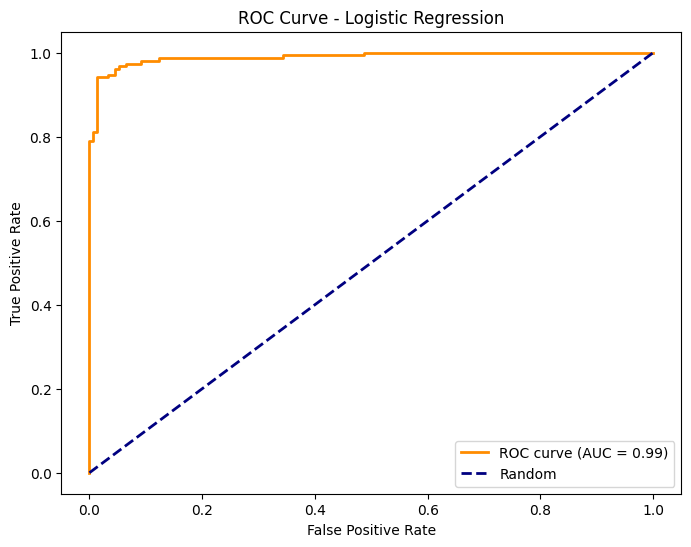

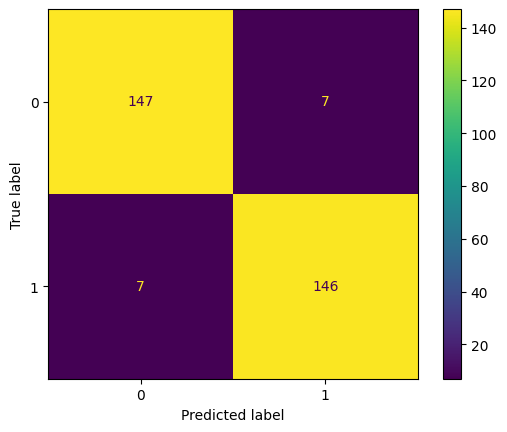

In [2]:
# train and test the model
lr_model = lr()
lr_model.fit(X_train, Y_train.squeeze())
Y_pred = lr_model.predict(X_test)
Y_probs = lr_model.predict_proba(X_test)[:, 1]

# print(lr_model.predict_proba(X_test), lr_model.predict_proba(X_test)[:,1])

# performance metrics
conf_mat = confusion_matrix(Y_test, Y_pred)
accuracy = accuracy_score(Y_test, Y_pred)
fpr, tpr, thresholds = roc_curve(Y_test, Y_probs)

# Area Under the Curve (AUC)
roc_auc = auc(fpr, tpr)

print("Confusion Matrix:")
print(conf_mat)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.legend(loc='lower right')
plt.show()


ConfusionMatrixDisplay.from_predictions(Y_test, Y_pred, cmap='viridis')


#### Linear Discriminant Analysis

Confusion Matrix:
[[152   2]
 [ 14 139]]
Accuracy: 94.79%


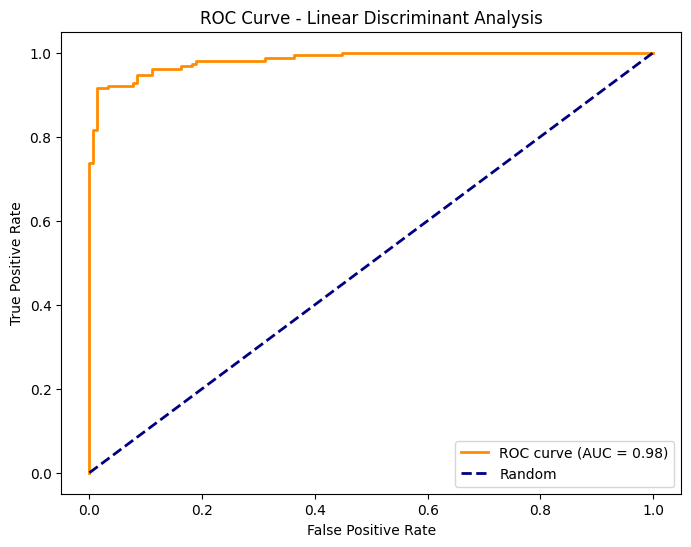

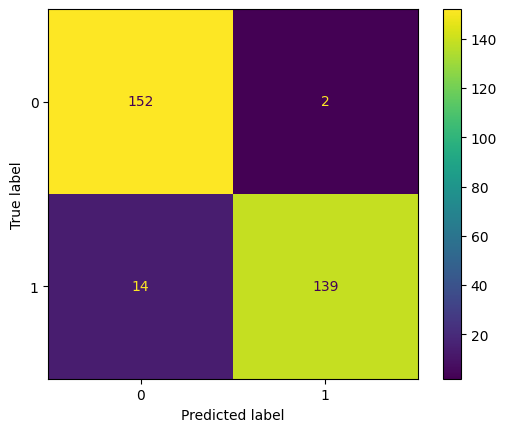

In [3]:
# train and test model
lda_model = lda()
lda_model.fit(X_train, Y_train.squeeze())
Y_pred = lda_model.predict(X_test)
Y_probs = lda_model.predict_proba(X_test)[:, 1]

# performance
conf_mat = confusion_matrix(Y_test, Y_pred)
accuracy = accuracy_score(Y_test, Y_pred)
fpr, tpr, thresholds = roc_curve(Y_test, Y_probs)

# Compute Area Under the Curve (AUC)
roc_auc = auc(fpr, tpr)

print("Confusion Matrix:")
print(conf_mat)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Linear Discriminant Analysis')
plt.legend(loc='lower right')
plt.show()

ConfusionMatrixDisplay.from_predictions(Y_test, Y_pred, cmap='viridis')


In [12]:
# Predicted label of every class 

output = {'true label': Y_test.squeeze(),
          'predicted_label': Y_pred.squeeze()}

classification = pd.DataFrame(output)

# print(classification)